# Importando Bibliotecas

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from scipy.stats import normaltest

import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import shap

import warnings
warnings.filterwarnings('ignore')

# Funções

In [2]:
def normal_test(array, alpha=0.05):
    p = normaltest(array).pvalue
    if p < alpha:
        print(f'Rejeita H0. A distribuição NÃO está normalmente distribuída')
    else:
        print(f'Aceita H0. A distribuição está normalmente distribuída. P-valor = {p} >= {alpha}')

# Lendo os Dados

In [3]:
df = pd.read_csv('../Dados/df_final.csv')
df.head()

,data,vendas,vendas_Outra_Faculdade,vendas_PUCRIO,vendas_UFABC,vendas_UFF,vendas_UFMG,vendas_UFPE,vendas_UFRJ,vendas_UFSC,...,vendas_Outra_Cidade,vendas_Porto_Alegre,vendas_Recife,vendas_Rio_de_Janeiro,vendas_Salvador,vendas_Santo_Andre,vendas_Sao_Carlos,vendas_Sao_Paulo,trend,seasonal
0,2018-01-01,1819.00000,618.00000,100.00000,17.00000,194.00000,34.00000,71.00000,407.00000,23.00000,...,587.00000,11.00000,51.00000,521.00000,25.00000,9.00000,14.00000,187.00000,NaN,-2401.78443
1,2018-02-01,2012.00000,652.00000,98.00000,22.00000,199.00000,34.00000,85.00000,492.00000,28.00000,...,654.00000,11.00000,62.00000,592.00000,23.00000,13.00000,14.00000,205.00000,NaN,-1835.22888
2,2018-03-01,4035.00000,926.00000,229.00000,16.00000,357.00000,46.00000,163.00000,1473.00000,30.00000,...,1103.00000,14.00000,123.00000,1544.00000,22.00000,12.00000,29.00000,282.00000,NaN,935.86834
3,2018-04-01,4305.00000,1204.00000,189.00000,186.00000,512.00000,96.00000,134.00000,1098.00000,151.00000,...,1299.00000,21.00000,105.00000,1300.00000,38.00000,40.00000,27.00000,359.00000,NaN,670.79890
4,2018-05-01,3956.00000,1462.00000,176.00000,130.00000,349.00000,212.00000,158.00000,721.00000,122.00000,...,1250.00000,20.00000,110.00000,1065.00000,41.00000,39.00000,31.00000,300.00000,NaN,267.66001


---
# Time Series

## Prophet

In [4]:
df_prophet = df[['data', 'vendas']]
df_prophet.rename(columns={
    'data': 'ds',
    'vendas': 'y'
}, inplace=True)

In [5]:
df_prophet_treino, df_prophet_teste = train_test_split(df_prophet, train_size=0.75, shuffle=False)

In [6]:
model = Prophet()
model.fit(df_prophet_treino)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Performance

In [7]:
forecast = model.predict(df_prophet_teste)

mse = metrics.mean_squared_error(df_prophet_teste['y'], forecast['yhat'])
rmse = metrics.mean_squared_error(df_prophet_teste['y'], forecast['yhat'], squared=False)
mad = metrics.mean_absolute_error(df_prophet_teste['y'], forecast['yhat'])
mape = metrics.mean_absolute_percentage_error(df_prophet_teste['y'], forecast['yhat'])

print(f'''
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      EQM: 2432332.38
      REQM: 1559.59
      MAD: 1415.49
      MAPE: 13.46%
      


In [8]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto',x=forecast['ds'], y=forecast['yhat'], marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_prophet_teste['ds'], y=df_prophet_teste['y'], marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (Prophet)')
fig.show()

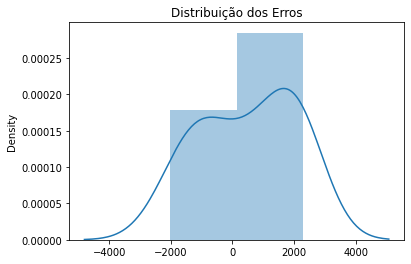

In [9]:
erro_prophet = df_prophet_teste['y'].values - forecast['yhat'].values
sns.distplot(erro_prophet)
plt.title('Distribuição dos Erros')
plt.show()

In [10]:
normal_test(erro_prophet)

Aceita H0. A distribuição está normalmente distribuída. P-valor = 0.16786421087169454 >= 0.05


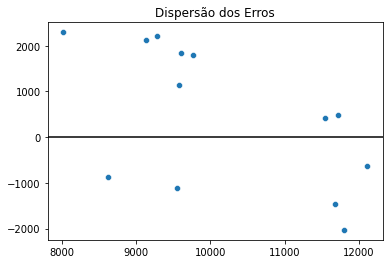

In [11]:
sns.scatterplot(forecast['yhat'].values, erro_prophet)
plt.axhline(0, color='black')
plt.title('Dispersão dos Erros')
plt.show()

---
# Regressões

## Feature Engineering

### Criando LAGs

In [12]:
df_r = df.copy().drop(['vendas_Outra_Faculdade', 'vendas_Outra_Cidade', 'trend'], axis=1)
df_r.dropna(axis=0, inplace=True)
df_r.head()

,data,vendas,vendas_PUCRIO,vendas_UFABC,vendas_UFF,vendas_UFMG,vendas_UFPE,vendas_UFRJ,vendas_UFSC,vendas_UNICAMP,...,vendas_Natal,vendas_Niteroi,vendas_Porto_Alegre,vendas_Recife,vendas_Rio_de_Janeiro,vendas_Salvador,vendas_Santo_Andre,vendas_Sao_Carlos,vendas_Sao_Paulo,seasonal
0,2018-01-01,1819.00000,100.00000,17.00000,194.00000,34.00000,71.00000,407.00000,23.00000,200.00000,...,3.00000,79.00000,11.00000,51.00000,521.00000,25.00000,9.00000,14.00000,187.00000,-2401.78443
1,2018-02-01,2012.00000,98.00000,22.00000,199.00000,34.00000,85.00000,492.00000,28.00000,219.00000,...,2.00000,81.00000,11.00000,62.00000,592.00000,23.00000,13.00000,14.00000,205.00000,-1835.22888
2,2018-03-01,4035.00000,229.00000,16.00000,357.00000,46.00000,163.00000,1473.00000,30.00000,577.00000,...,9.00000,171.00000,14.00000,123.00000,1544.00000,22.00000,12.00000,29.00000,282.00000,935.86834
3,2018-04-01,4305.00000,189.00000,186.00000,512.00000,96.00000,134.00000,1098.00000,151.00000,434.00000,...,4.00000,232.00000,21.00000,105.00000,1300.00000,38.00000,40.00000,27.00000,359.00000,670.79890
4,2018-05-01,3956.00000,176.00000,130.00000,349.00000,212.00000,158.00000,721.00000,122.00000,376.00000,...,8.00000,155.00000,20.00000,110.00000,1065.00000,41.00000,39.00000,31.00000,300.00000,267.66001


In [13]:
lag_columns = ['vendas_PUCRIO', 'vendas_UFABC', 'vendas_UFF', 'vendas_UFMG', 'vendas_UFPE', 'vendas_UFRJ', 'vendas_UFSC', 'vendas_UNICAMP', 'vendas_USP', 'vendas_UTFPR', 'vendas_Belo_Horizonte',
       'vendas_Brasilia', 'vendas_Campinas', 'vendas_Campo_Grande',
       'vendas_Curitiba', 'vendas_Florianopolis', 'vendas_Fortaleza',
       'vendas_Goiania', 'vendas_Joinville', 'vendas_Juiz_de_Fora',
       'vendas_Manaus', 'vendas_Natal', 'vendas_Niteroi',
       'vendas_Porto_Alegre', 'vendas_Recife', 'vendas_Rio_de_Janeiro',
       'vendas_Salvador', 'vendas_Santo_Andre', 'vendas_Sao_Carlos',
       'vendas_Sao_Paulo']

In [14]:
for column in lag_columns:
    for lag in range(1, 4):
        novo_nome = f'{column}_LAG_{lag}'
        df_r[novo_nome] = df_r[column].shift(periods=lag, fill_value=0)

In [15]:
df_r['seasonal_LAG_12'] = df_r['seasonal'].shift(periods=12, fill_value=0)
df_r['vendas_LAG_12'] = df_r['vendas'].shift(periods=12, fill_value=0)

In [16]:
df_r.drop(lag_columns, axis=1, inplace=True)
df_r.drop('seasonal', axis=1, inplace=True)
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,vendas_Santo_Andre_LAG_2,vendas_Santo_Andre_LAG_3,vendas_Sao_Carlos_LAG_1,vendas_Sao_Carlos_LAG_2,vendas_Sao_Carlos_LAG_3,vendas_Sao_Paulo_LAG_1,vendas_Sao_Paulo_LAG_2,vendas_Sao_Paulo_LAG_3,seasonal_LAG_12,vendas_LAG_12
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0.00000,0.00000,14.00000,0.00000,0.00000,187.00000,0.00000,0.00000,0.00000,0.00000
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,9.00000,0.00000,14.00000,14.00000,0.00000,205.00000,187.00000,0.00000,0.00000,0.00000
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,13.00000,9.00000,29.00000,14.00000,14.00000,282.00000,205.00000,187.00000,0.00000,0.00000
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,12.00000,13.00000,27.00000,29.00000,14.00000,359.00000,282.00000,205.00000,0.00000,0.00000


### Criando Dummies - Mês

In [17]:
df_r['mes'] = pd.to_datetime(df_r['data']).dt.month_name()
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,vendas_Santo_Andre_LAG_3,vendas_Sao_Carlos_LAG_1,vendas_Sao_Carlos_LAG_2,vendas_Sao_Carlos_LAG_3,vendas_Sao_Paulo_LAG_1,vendas_Sao_Paulo_LAG_2,vendas_Sao_Paulo_LAG_3,seasonal_LAG_12,vendas_LAG_12,mes
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,January
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0.00000,14.00000,0.00000,0.00000,187.00000,0.00000,0.00000,0.00000,0.00000,February
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,0.00000,14.00000,14.00000,0.00000,205.00000,187.00000,0.00000,0.00000,0.00000,March
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,9.00000,29.00000,14.00000,14.00000,282.00000,205.00000,187.00000,0.00000,0.00000,April
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,13.00000,27.00000,29.00000,14.00000,359.00000,282.00000,205.00000,0.00000,0.00000,May


In [18]:
df_r = pd.get_dummies(df_r, columns=['mes'])
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,mes_December,mes_February,mes_January,mes_July,mes_June,mes_March,mes_May,mes_November,mes_October,mes_September
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,1,0,0,0,0,0,0,0
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0,1,0,0,0,0,0,0,0,0
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,0,0,0,0,0,1,0,0,0,0
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,0,0,0,0,0,0,0,0,0,0
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,0,0,0,0,0,0,1,0,0,0


### Divisão entre Treino e Teste

In [19]:
df_r_treino, df_r_teste = train_test_split(df_r, train_size=0.75, shuffle=False)

In [20]:
X_r = df_r.drop(['data', 'vendas'], axis=1)
y_r = df_r['vendas']

In [21]:
X_r_treino, X_r_teste, y_r_treino, y_r_teste = train_test_split(X_r, y_r, train_size=0.75, shuffle=False)

In [22]:
tss = TimeSeriesSplit(n_splits=10)

## Modelos

In [23]:
modelos = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(), SVR(), AdaBoostRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(), RandomForestRegressor(), HistGradientBoostingRegressor(), LGBMRegressor(), CatBoostRegressor(verbose=False)]

In [24]:
modelos_score = []

for modelo in modelos:
    pipe = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', modelo)
    ])
    cv = cross_val_score(pipe, X_r_treino, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
    modelos_score.append({'modelo': modelo, 'mape': cv.mean()*(-100), 'std': cv.std()*(100)})

In [25]:
modelos_score = pd.DataFrame(modelos_score)
modelos_score.sort_values(by='mape', ascending=True, inplace=True)
modelos_score

,modelo,mape,std
6,ExtraTreesRegressor(),20.57654,8.77861
8,RandomForestRegressor(),21.52313,8.29932
1,Ridge(),22.01866,10.03976
5,AdaBoostRegressor(),22.12202,6.74966
7,GradientBoostingRegressor(),22.28057,10.19396
11,<catboost.core.CatBoostRegressor object at 0x0...,22.54341,8.48459
0,LinearRegression(),23.75999,9.96971
3,DecisionTreeRegressor(),26.64778,15.68003
2,Lasso(),26.80369,15.32121
9,HistGradientBoostingRegressor(),29.81422,9.92709


### Linear Regression

In [26]:
linreg = LinearRegression()

linreg.fit(X_r_treino, y_r_treino)

LinearRegression()

##### Treino

In [27]:
linreg_pred_treino = linreg.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, linreg_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, linreg_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, linreg_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, linreg_pred_treino)

print(f'''
      Linear Regression - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Linear Regression - Treino
      EQM: 0.0
      REQM: 0.0
      MAD: 0.0
      MAPE: 0.0%
      


##### Teste

In [28]:
linreg_pred_teste = linreg.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, linreg_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, linreg_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, linreg_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, linreg_pred_teste)

print(f'''
      Linear Regression - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Linear Regression - Teste
      EQM: 13559960.23
      REQM: 3682.39
      MAD: 2991.56
      MAPE: 27.68%
      


### Ridge

In [29]:
ridge = Ridge()

ridge.fit(X_r_treino, y_r_treino)

Ridge()

##### Treino

In [30]:
ridge_pred_treino = ridge.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, ridge_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, ridge_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, ridge_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, ridge_pred_treino)

print(f'''
      Ridge Regression - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Ridge Regression - Treino
      EQM: 0.01
      REQM: 0.09
      MAD: 0.07
      MAPE: 0.0%
      


##### Teste

In [31]:
ridge_pred_teste = ridge.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, ridge_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, ridge_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, ridge_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, ridge_pred_teste)

print(f'''
      Ridge Regression - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Ridge Regression - Teste
      EQM: 13555033.59
      REQM: 3681.72
      MAD: 2991.01
      MAPE: 27.68%
      


### Decision Tree Regressor

In [32]:
dtreg = DecisionTreeRegressor()

dtreg.fit(X_r_treino, y_r_treino)

DecisionTreeRegressor()

##### Treino

In [33]:
dtreg_pred_treino = dtreg.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, dtreg_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, dtreg_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, dtreg_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, dtreg_pred_treino)

print(f'''
      Decision Tree Regressor - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Decision Tree Regressor - Treino
      EQM: 0.0
      REQM: 0.0
      MAD: 0.0
      MAPE: 0.0%
      


##### Teste

In [34]:
dtreg_pred_teste = dtreg.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, dtreg_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, dtreg_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, dtreg_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, dtreg_pred_teste)

print(f'''
      Decision Tree Regressor - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Decision Tree Regressor - Teste
      EQM: 6337857.31
      REQM: 2517.51
      MAD: 2129.62
      MAPE: 19.9%
      


### SVR

In [35]:
svr = SVR()

svr.fit(X_r_treino, y_r_treino)

SVR()

##### Treino

In [36]:
svr_pred_treino = svr.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, svr_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, svr_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, svr_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, svr_pred_treino)

print(f'''
      SVR - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      SVR - Treino
      EQM: 5752669.49
      REQM: 2398.47
      MAD: 1926.36
      MAPE: 39.4%
      


##### Teste

In [37]:
svr_pred_teste = svr.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, svr_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, svr_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, svr_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, svr_pred_teste)

print(f'''
      SVR - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      SVR - Teste
      EQM: 26473260.98
      REQM: 5145.22
      MAD: 4980.37
      MAPE: 45.79%
      


### AdaBoost

In [38]:
adaboost = AdaBoostRegressor()

adaboost.fit(X_r_treino, y_r_treino)

AdaBoostRegressor()

##### Treino

In [39]:
adaboost_pred_treino = adaboost.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, adaboost_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, adaboost_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, adaboost_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, adaboost_pred_treino)

print(f'''
      AdaBoost - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      AdaBoost - Treino
      EQM: 147147.0
      REQM: 383.6
      MAD: 307.82
      MAPE: 6.77%
      


##### Teste

In [40]:
adaboost_pred_teste = adaboost.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, adaboost_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, adaboost_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, adaboost_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, adaboost_pred_teste)

print(f'''
      AdaBoost - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      AdaBoost - Teste
      EQM: 5357387.55
      REQM: 2314.6
      MAD: 1956.87
      MAPE: 17.5%
      


### Extra Trees Regressor

In [41]:
et_reg = ExtraTreesRegressor()

et_reg.fit(X_r_treino, y_r_treino)

ExtraTreesRegressor()

##### Treino

In [42]:
et_reg_pred_treino = et_reg.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, et_reg_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, et_reg_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, et_reg_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, et_reg_pred_treino)

print(f'''
      Extra Trees - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Extra Trees - Treino
      EQM: 0.0
      REQM: 0.0
      MAD: 0.0
      MAPE: 0.0%
      


##### Teste

In [43]:
et_reg_pred_teste = et_reg.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, et_reg_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, et_reg_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, et_reg_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, et_reg_pred_teste)

print(f'''
      Extra Trees - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Extra Trees - Teste
      EQM: 5610434.81
      REQM: 2368.64
      MAD: 2056.55
      MAPE: 18.43%
      


### Gradient Boosting Regressor

In [44]:
gb_reg = GradientBoostingRegressor()

gb_reg.fit(X_r_treino, y_r_treino)

GradientBoostingRegressor()

##### Treino

In [45]:
gb_reg_pred_treino = gb_reg.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, gb_reg_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, gb_reg_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, gb_reg_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, gb_reg_pred_treino)

print(f'''
      Gradient Boosting - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Gradient Boosting - Treino
      EQM: 6.11
      REQM: 2.47
      MAD: 2.07
      MAPE: 0.04%
      


##### Teste

In [46]:
gb_reg_pred_teste = gb_reg.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, gb_reg_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, gb_reg_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, gb_reg_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, gb_reg_pred_teste)

print(f'''
      Gradient Boosting - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Gradient Boosting - Teste
      EQM: 4631850.85
      REQM: 2152.17
      MAD: 1818.07
      MAPE: 16.23%
      


### Random Forest Regressor

In [47]:
rf_reg = RandomForestRegressor()

rf_reg.fit(X_r_treino, y_r_treino)

RandomForestRegressor()

##### Treino

In [48]:
rf_reg_pred_treino = rf_reg.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, rf_reg_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, rf_reg_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, rf_reg_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, rf_reg_pred_treino)

print(f'''
      Random Forest - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Random Forest - Treino
      EQM: 184616.26
      REQM: 429.67
      MAD: 346.19
      MAPE: 6.67%
      


##### Teste

In [49]:
rf_reg_pred_teste = rf_reg.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, rf_reg_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, rf_reg_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, rf_reg_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, rf_reg_pred_teste)

print(f'''
      Random Forest - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Random Forest - Teste
      EQM: 6235283.04
      REQM: 2497.05
      MAD: 2245.64
      MAPE: 20.16%
      


### Histocastic Gradient Boosting

In [50]:
histgrad = HistGradientBoostingRegressor()

histgrad.fit(X_r_treino, y_r_treino)

HistGradientBoostingRegressor()

##### Treino

In [51]:
histgrad_pred_treino = histgrad.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, histgrad_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, histgrad_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, histgrad_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, histgrad_pred_treino)

print(f'''
      Histocastic Gradient Boosting - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Histocastic Gradient Boosting - Treino
      EQM: 5648125.62
      REQM: 2376.58
      MAD: 1942.34
      MAPE: 42.26%
      


##### Teste

In [52]:
histgrad_pred_teste = histgrad.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, histgrad_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, histgrad_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, histgrad_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, histgrad_pred_teste)

print(f'''
      Histocastic Gradient Boosting - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Histocastic Gradient Boosting - Teste
      EQM: 23023330.41
      REQM: 4798.26
      MAD: 4620.77
      MAPE: 42.36%
      


### LGBM

In [53]:
lgbm = LGBMRegressor()

lgbm.fit(X_r_treino, y_r_treino)

LGBMRegressor()

##### Treino

In [54]:
lgbm_pred_treino = lgbm.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, lgbm_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, lgbm_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, lgbm_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, lgbm_pred_treino)

print(f'''
      LGBM - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      LGBM - Treino
      EQM: 5648125.62
      REQM: 2376.58
      MAD: 1942.34
      MAPE: 42.26%
      


##### Teste

In [55]:
lgbm_pred_teste = lgbm.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, lgbm_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, lgbm_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, lgbm_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, lgbm_pred_teste)

print(f'''
      LGBM - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      LGBM - Teste
      EQM: 23023330.41
      REQM: 4798.26
      MAD: 4620.77
      MAPE: 42.36%
      


### CatBoost

In [56]:
catboost = CatBoostRegressor(verbose=False)

catboost.fit(X_r_treino, y_r_treino)

##### Treino

In [57]:
catboost_pred_treino = catboost.predict(X_r_treino)

mse = metrics.mean_squared_error(y_r_treino, catboost_pred_treino)
rmse = metrics.mean_squared_error(y_r_treino, catboost_pred_treino, squared=False)
mad = metrics.mean_absolute_error(y_r_treino, catboost_pred_treino)
mape = metrics.mean_absolute_percentage_error(y_r_treino, catboost_pred_treino)

print(f'''
      CatBoost - Treino
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      CatBoost - Treino
      EQM: 12.4
      REQM: 3.52
      MAD: 3.01
      MAPE: 0.06%
      


##### Teste

In [58]:
catboost_pred_teste = catboost.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, catboost_pred_teste)
rmse = metrics.mean_squared_error(y_r_teste, catboost_pred_teste, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, catboost_pred_teste)
mape = metrics.mean_absolute_percentage_error(y_r_teste, catboost_pred_teste)

print(f'''
      CatBoost - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      CatBoost - Teste
      EQM: 8120071.33
      REQM: 2849.57
      MAD: 2622.77
      MAPE: 23.71%
      


# Extra Trees Regressor

In [59]:
pipe_et = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', ExtraTreesRegressor())
])

In [60]:
pipe_et.fit(X_r_treino, y_r_treino)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model', ExtraTreesRegressor())])

In [61]:
pred_teste_et = pipe_et.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, pred_teste_et)
rmse = metrics.mean_squared_error(y_r_teste, pred_teste_et, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, pred_teste_et)
mape = metrics.mean_absolute_percentage_error(y_r_teste, pred_teste_et)

print(f'''
      ExtraTrees Regression Standard - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      ExtraTrees Regression Standard - Teste
      EQM: 5389106.77
      REQM: 2321.44
      MAD: 2035.48
      MAPE: 18.34%
      


In [62]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto', x=df_r_teste['data'], y=pred_teste_et, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (ExtraTrees Regression)')
fig.show()

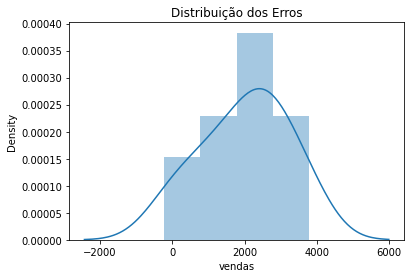

In [63]:
erro_et = y_r_teste - pred_teste_et
sns.distplot(erro_et)
plt.title('Distribuição dos Erros')
plt.show()

In [64]:
normal_test(erro_et)

Aceita H0. A distribuição está normalmente distribuída. P-valor = 0.764428661162145 >= 0.05


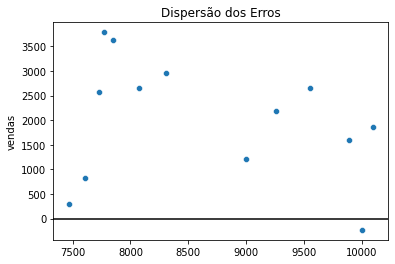

In [65]:
sns.scatterplot(pred_teste_et, erro_et)
plt.axhline(0, color='black')
plt.title('Dispersão dos Erros')
plt.show()

# Random Forest

In [66]:
pipe_rf = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', RandomForestRegressor())
])

In [67]:
pipe_rf.fit(X_r_treino, y_r_treino)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model', RandomForestRegressor())])

In [68]:
pred_teste_rf = pipe_rf.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, pred_teste_rf)
rmse = metrics.mean_squared_error(y_r_teste, pred_teste_rf, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, pred_teste_rf)
mape = metrics.mean_absolute_percentage_error(y_r_teste, pred_teste_rf)

print(f'''
      Random Forest Regression Standard - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Random Forest Regression Standard - Teste
      EQM: 6637088.25
      REQM: 2576.25
      MAD: 2344.14
      MAPE: 21.14%
      


In [69]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto', x=df_r_teste['data'], y=pred_teste_rf, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (Random Forest Regression)')
fig.show()

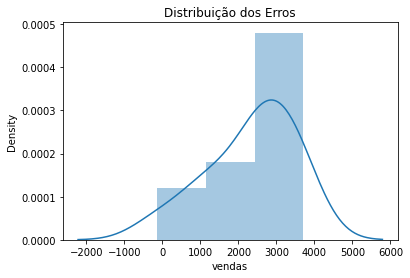

In [70]:
erro_rf = y_r_teste - pred_teste_rf
sns.distplot(erro_rf)
plt.title('Distribuição dos Erros')
plt.show()

In [71]:
normal_test(erro_rf)

Aceita H0. A distribuição está normalmente distribuída. P-valor = 0.3699641228835371 >= 0.05


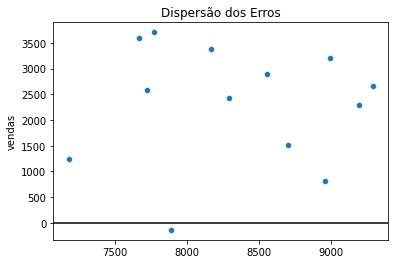

In [72]:
sns.scatterplot(pred_teste_rf, erro_rf)
plt.axhline(0, color='black')
plt.title('Dispersão dos Erros')
plt.show()

# Plot dos Três Métodos

In [73]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto Prophet',x=forecast['ds'], y=forecast['yhat'], marker={'color': 'green'}),
    go.Scatter(name='Previsto ExtraTrees', x=df_r_teste['data'], y=pred_teste_et, marker={'color': 'orange'}),
    go.Scatter(name='Previsto RandomForest', x=df_r_teste['data'], y=pred_teste_rf, marker={'color': 'blue'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto')
fig.show()

# Ensemble Voting Regressor

In [74]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto Prophet',x=forecast['ds'], y=forecast['yhat'], marker={'color': 'green'}),
    go.Scatter(name='Previsto Regressão Linear',x=forecast['ds'], y=linreg_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Previsto Ridge',x=forecast['ds'], y=ridge_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Previsto Decision Tree',x=forecast['ds'], y=dtreg_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Previsto SVR',x=forecast['ds'], y=svr_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Previsto AdaBoost',x=forecast['ds'], y=adaboost_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Previsto ExtraTrees', x=df_r_teste['data'], y=pred_teste_et, marker={'color': 'orange'}),
    go.Scatter(name='Previsto Gradient Boosting',x=forecast['ds'], y=gb_reg_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Previsto RandomForest', x=df_r_teste['data'], y=pred_teste_rf, marker={'color': 'blue'}),
    go.Scatter(name='Previsto Histocastic Gradient Boosting',x=forecast['ds'], y=histgrad_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Previsto LGBM',x=forecast['ds'], y=lgbm_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Previsto CatBoost',x=forecast['ds'], y=catboost_pred_teste, marker={'color': 'black'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto')
fig.show()

In [75]:
estimators = [('linreg', LinearRegression()), ('gradboost', GradientBoostingRegressor())]

voting = VotingRegressor(estimators=estimators)

In [76]:
pipe_ensemble = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', voting)
])

In [77]:
pipe_ensemble.fit(X_r_treino, y_r_treino)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model',
                 VotingRegressor(estimators=[('linreg', LinearRegression()),
                                             ('gradboost',
                                              GradientBoostingRegressor())]))])

In [78]:
pred_teste_ensemble = pipe_ensemble.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, pred_teste_ensemble)
rmse = metrics.mean_squared_error(y_r_teste, pred_teste_ensemble, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, pred_teste_ensemble)
mape = metrics.mean_absolute_percentage_error(y_r_teste, pred_teste_ensemble)

print(f'''
      Ensemble Voting Regression Standard - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Ensemble Voting Regression Standard - Teste
      EQM: 6382294.94
      REQM: 2526.32
      MAD: 2125.32
      MAPE: 19.17%
      


### Tuning

In [79]:
weights = [(90,10), (80,20), (70,30), (60,40), (50,50), (40,60), (30,70), (20,80), (10,90)]
estimators = [('linreg', LinearRegression()), ('gradboost', GradientBoostingRegressor())]

for weight in weights:
    print(weight)

    voting = VotingRegressor(estimators=estimators, weights=weight)
    pipe_ensemble = Pipeline(steps=[
        ('preprocessor', StandardScaler()),
        ('model', voting)
    ])
    pipe_ensemble.fit(X_r_treino, y_r_treino)
    pred = pipe_ensemble.predict(X_r_teste)
    mape = metrics.mean_absolute_percentage_error(y_r_teste, pred)
    print(f'''
          {weight} - MAPE: {round(mape*100,2)}%
          ''')

(90, 10)

          (90, 10) - MAPE: 22.45%
          
(80, 20)

          (80, 20) - MAPE: 21.5%
          
(70, 30)

          (70, 30) - MAPE: 20.66%
          
(60, 40)

          (60, 40) - MAPE: 20.13%
          
(50, 50)

          (50, 50) - MAPE: 19.45%
          
(40, 60)

          (40, 60) - MAPE: 19.23%
          
(30, 70)

          (30, 70) - MAPE: 19.53%
          
(20, 80)

          (20, 80) - MAPE: 17.47%
          
(10, 90)

          (10, 90) - MAPE: 17.7%
          


In [80]:
estimators = [('linreg', LinearRegression()), ('gradboost', GradientBoostingRegressor())]

voting = VotingRegressor(estimators=estimators, weights=(10, 90))

pipe_ensemble_tuned = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', voting)
])

pipe_ensemble_tuned.fit(X_r_treino, y_r_treino)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model',
                 VotingRegressor(estimators=[('linreg', LinearRegression()),
                                             ('gradboost',
                                              GradientBoostingRegressor())],
                                 weights=(10, 90)))])

In [81]:
pred_teste_ensemble_tuned = pipe_ensemble_tuned.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, pred_teste_ensemble_tuned)
rmse = metrics.mean_squared_error(y_r_teste, pred_teste_ensemble_tuned, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, pred_teste_ensemble_tuned)
mape = metrics.mean_absolute_percentage_error(y_r_teste, pred_teste_ensemble_tuned)

print(f'''
      Ensemble Voting Regression Standard - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      Ensemble Voting Regression Standard - Teste
      EQM: 5859199.06
      REQM: 2420.58
      MAD: 2046.01
      MAPE: 18.17%
      


In [82]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto', x=df_r_teste['data'], y=pred_teste_ensemble_tuned, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (Voting Ensemble Regression)')
fig.show()

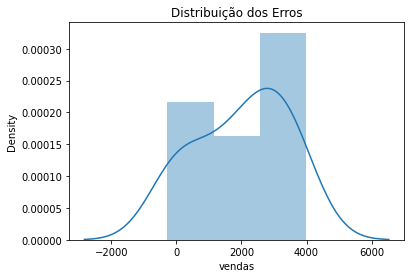

In [83]:
erro_ensemble = y_r_teste - pred_teste_ensemble_tuned
sns.distplot(erro_ensemble)
plt.title('Distribuição dos Erros')
plt.show()

In [84]:
normal_test(erro_ensemble)

Aceita H0. A distribuição está normalmente distribuída. P-valor = 0.4034504655022684 >= 0.05


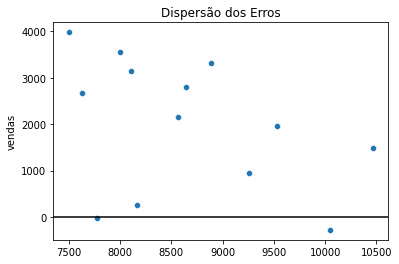

In [85]:
sns.scatterplot(pred_teste_ensemble_tuned, erro_ensemble)
plt.axhline(0, color='black')
plt.title('Dispersão dos Erros')
plt.show()

# Interpretação

### Feature Importance

In [86]:
feat_importances = pd.Series(pipe_et['model'].feature_importances_, index=X_r_treino.columns)

<AxesSubplot:title={'center':'Feature Importances'}>

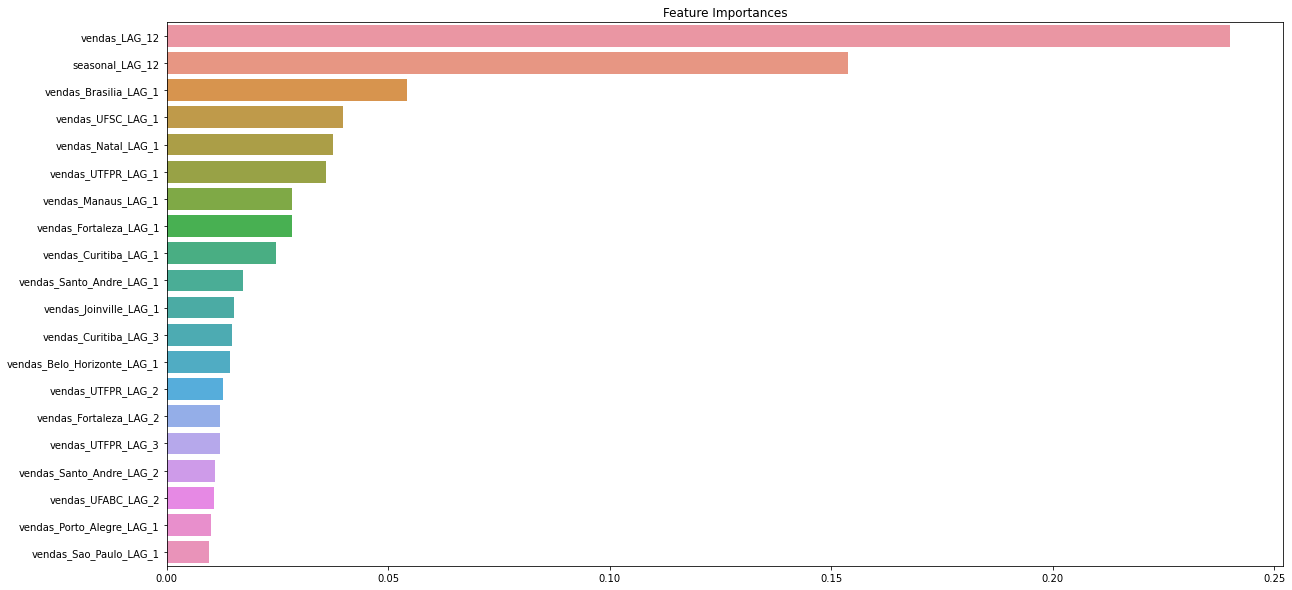

In [87]:
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
sns.barplot(x=feat_importances.nlargest(20), y=feat_importances.nlargest(20).index, orient='h')

### Shap

In [88]:
shap.initjs()

In [89]:
explainer = shap.TreeExplainer(pipe_et['model'])
shap_values = explainer.shap_values(X_r_treino)

##### Summary Plot

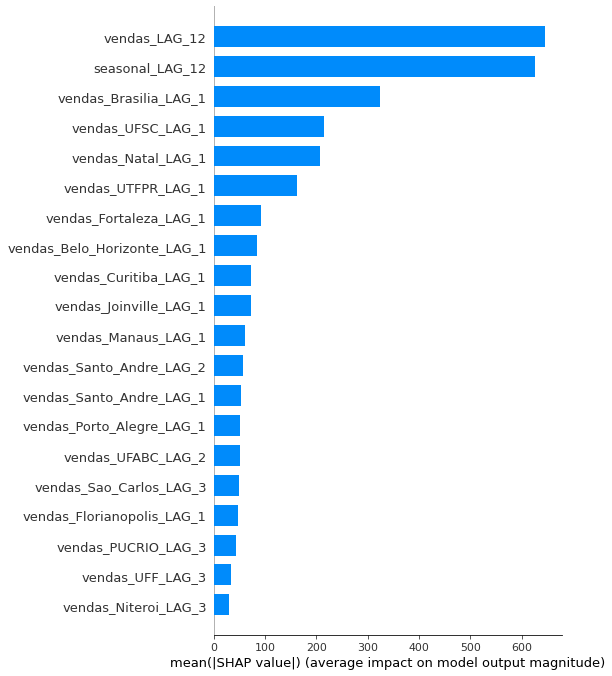

In [90]:
shap.summary_plot(shap_values, X_r_treino, plot_type='bar')

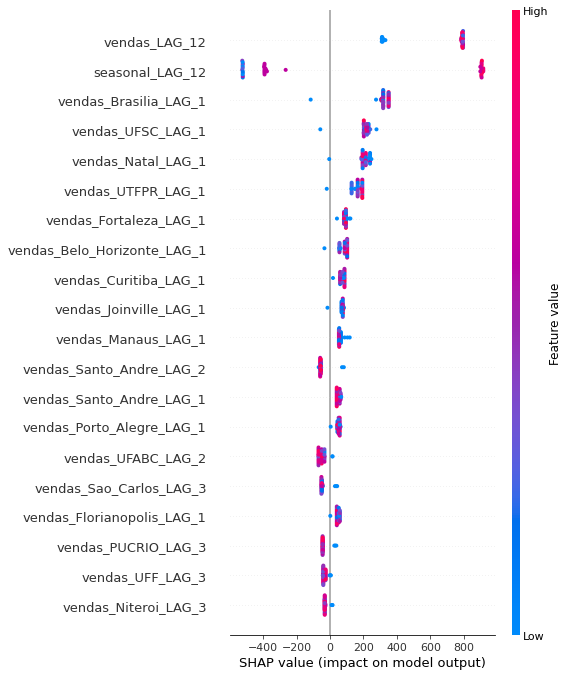

In [91]:
shap.summary_plot(shap_values, X_r_treino)

##### Dependence Plot

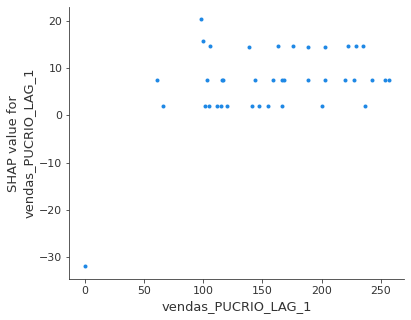

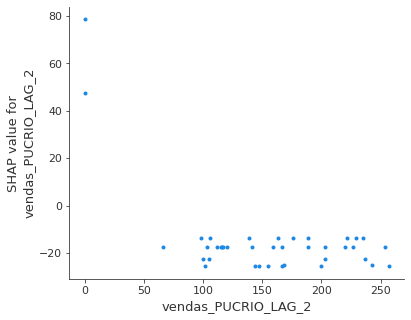

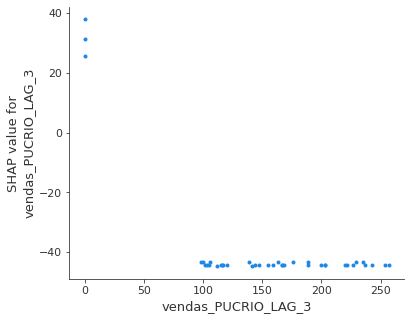

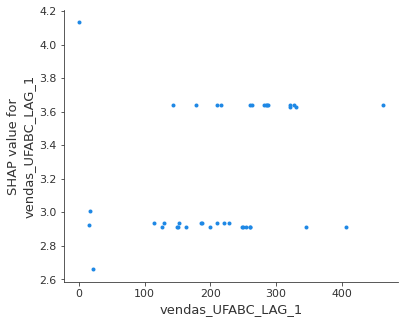

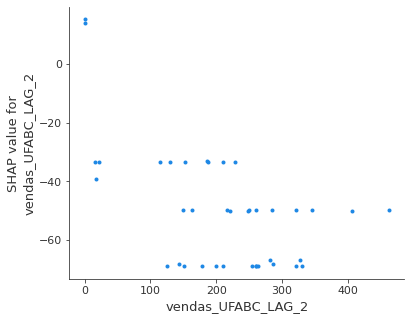

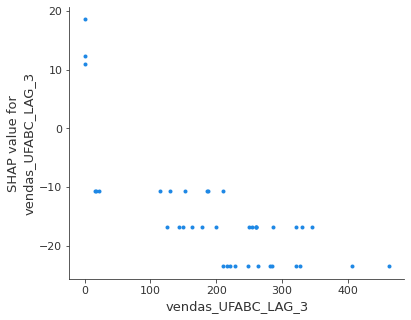

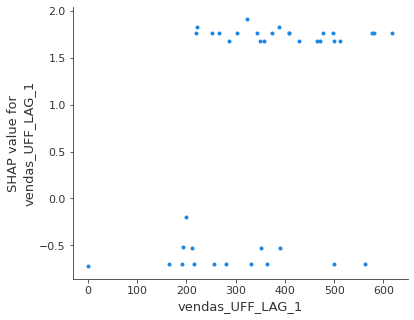

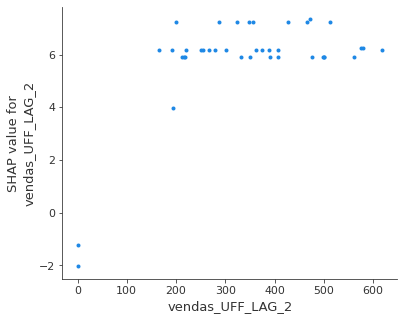

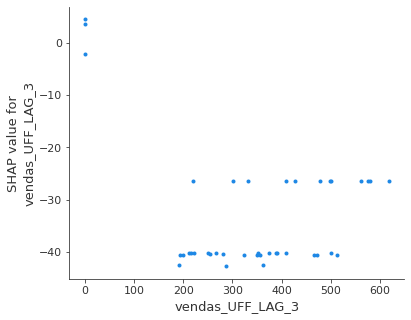

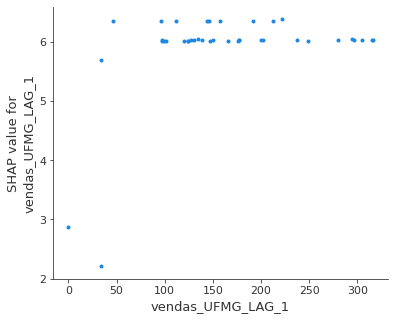

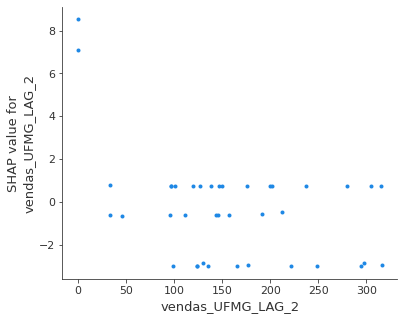

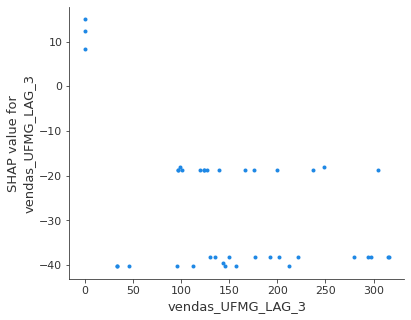

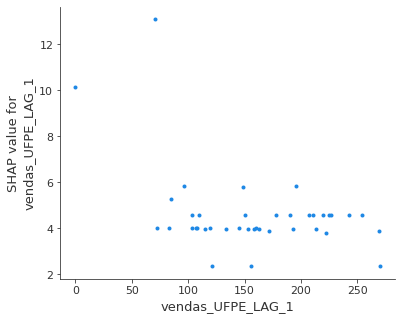

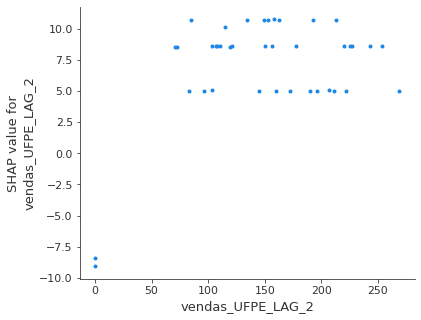

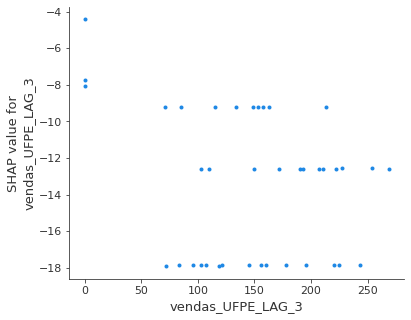

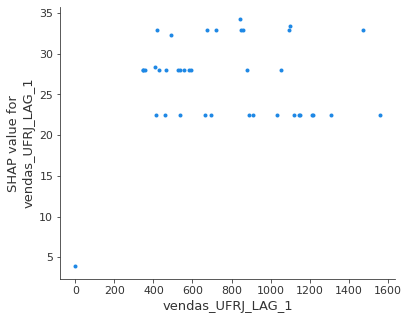

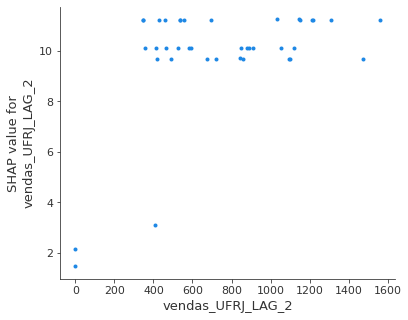

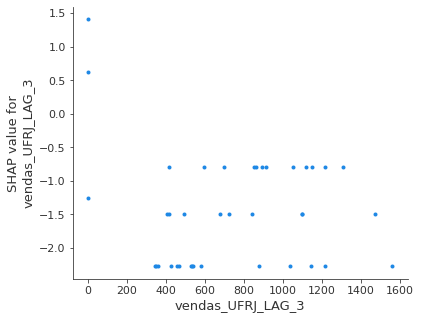

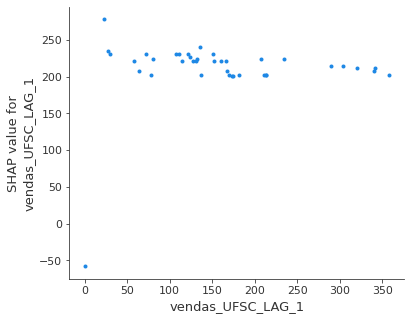

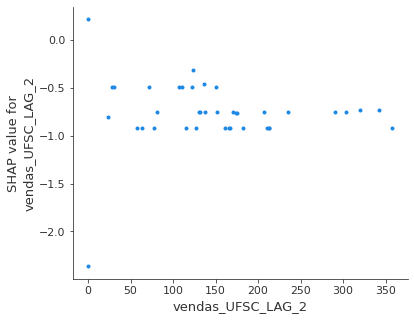

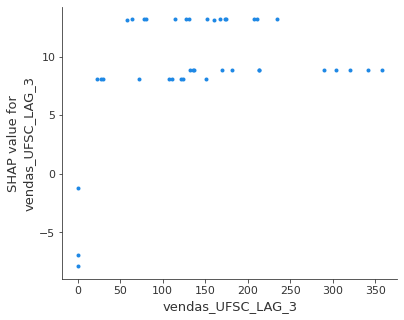

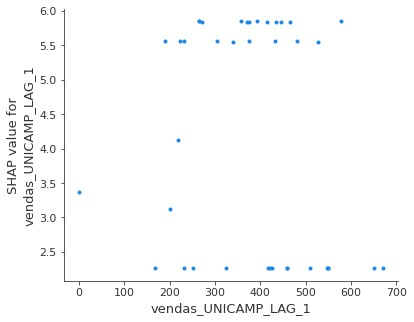

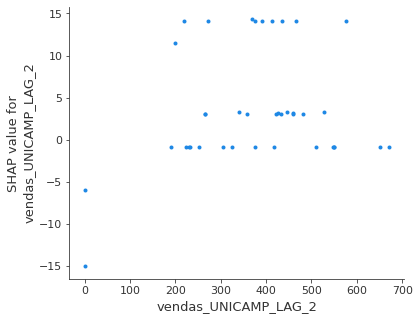

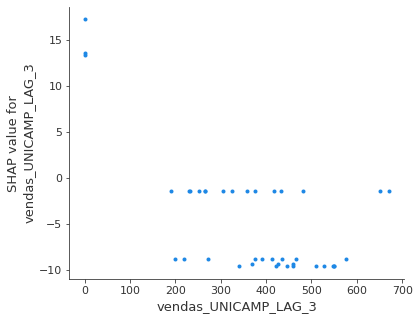

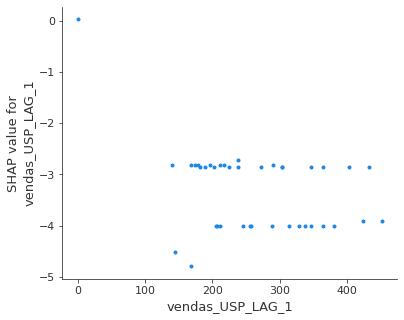

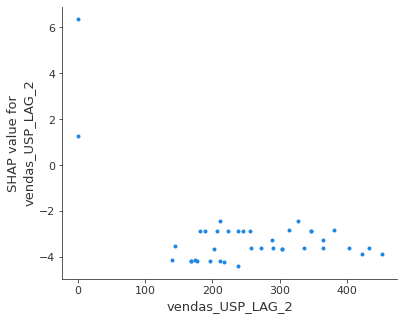

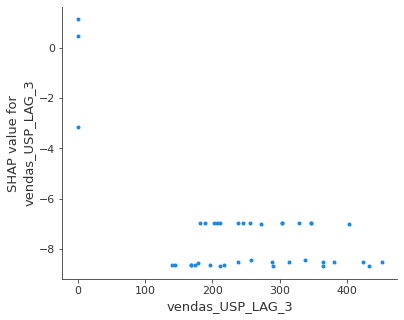

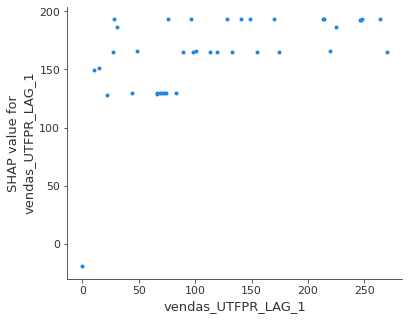

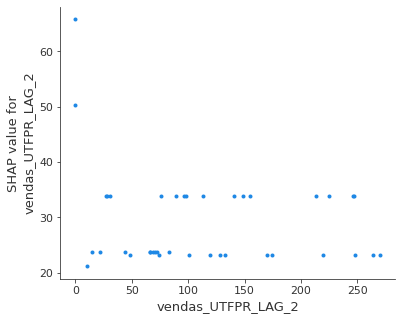

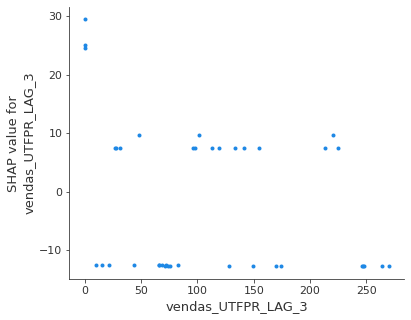

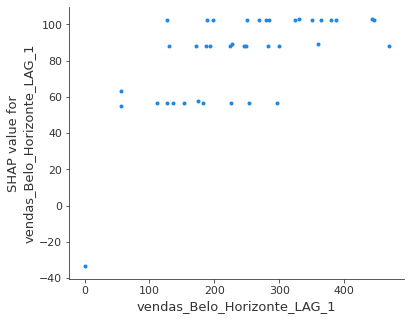

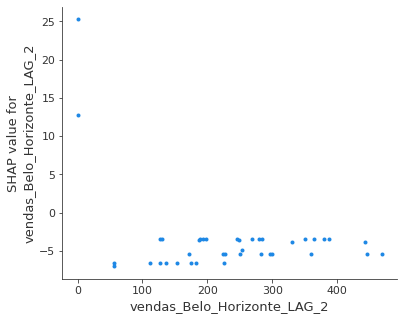

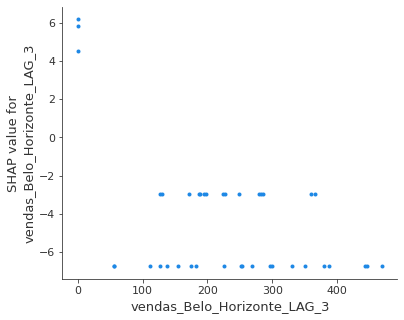

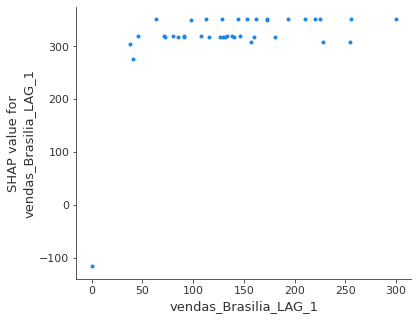

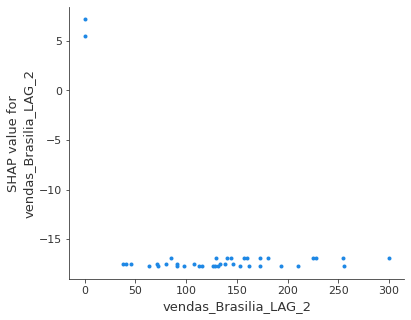

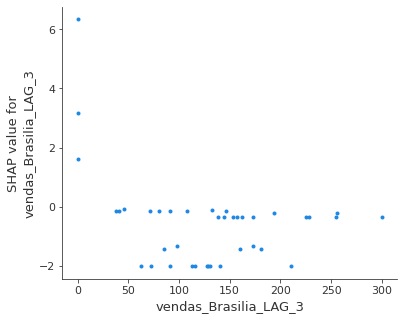

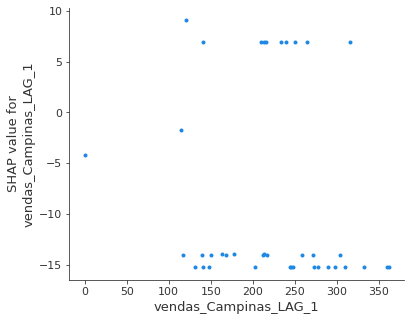

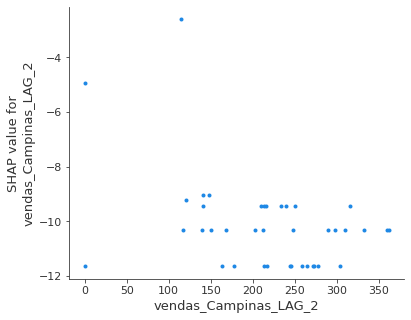

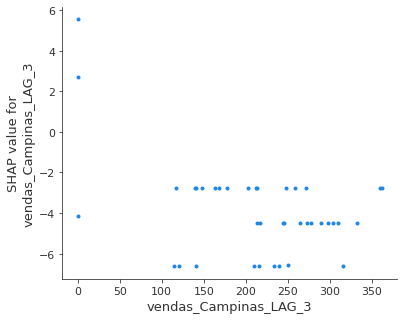

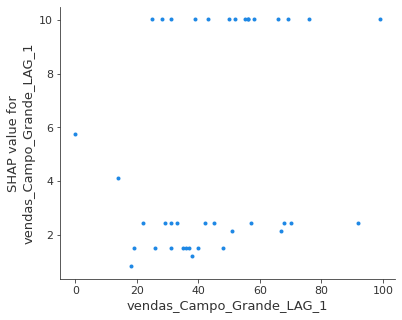

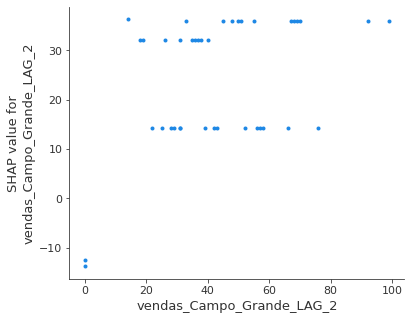

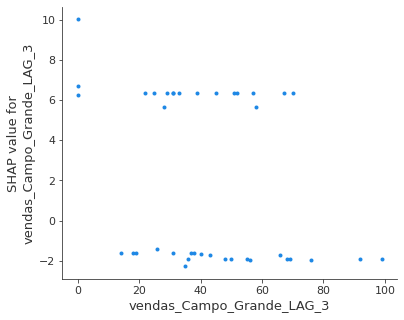

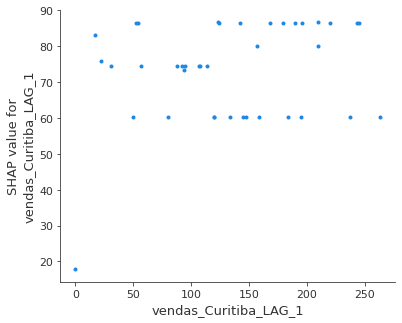

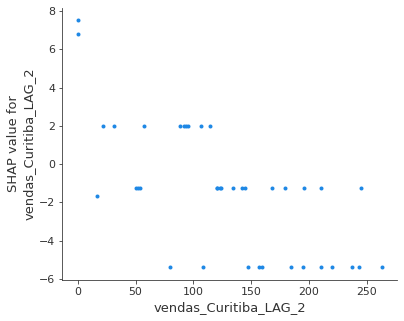

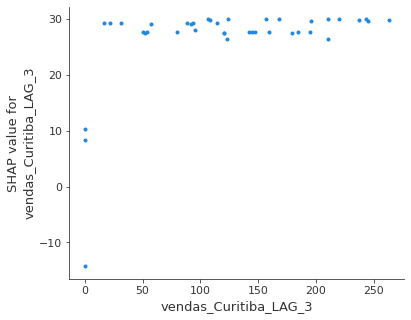

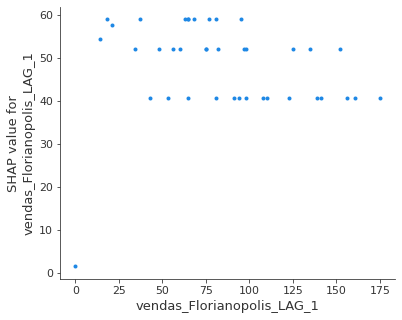

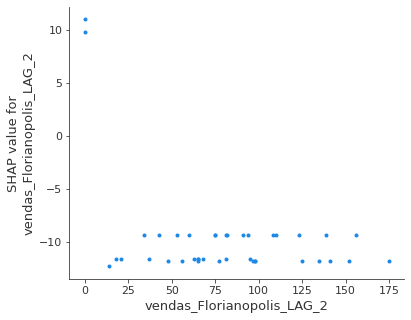

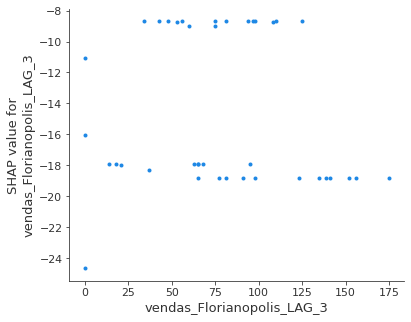

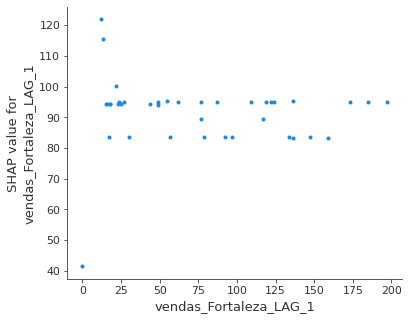

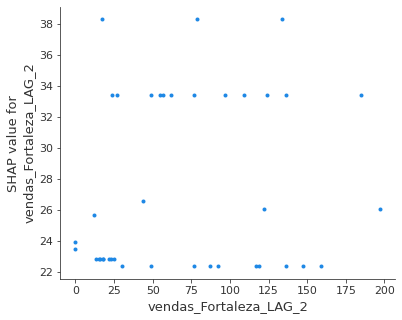

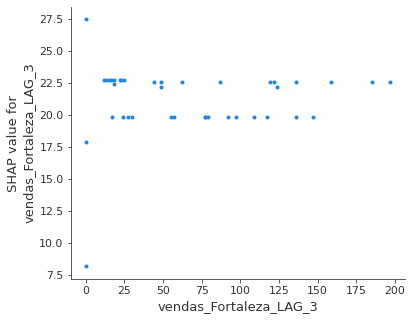

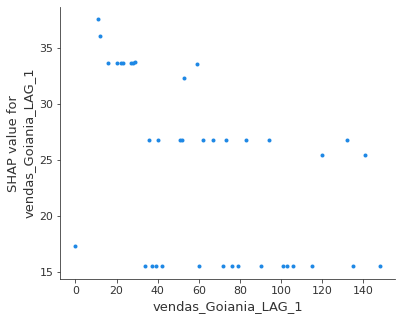

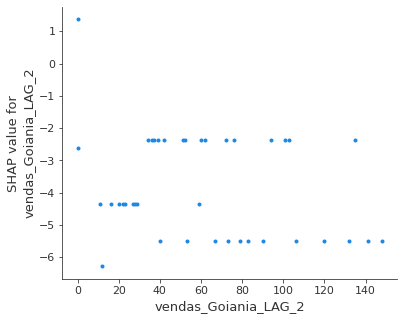

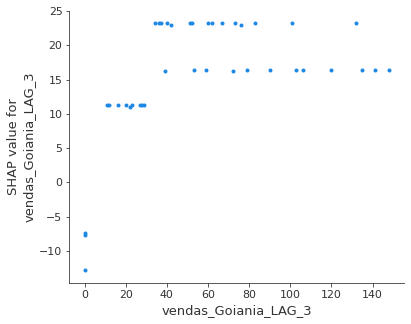

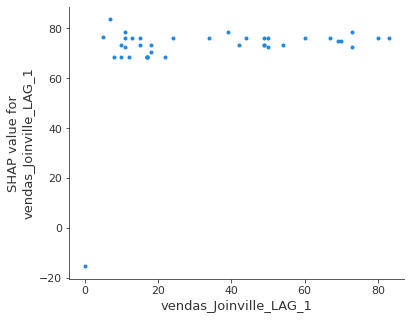

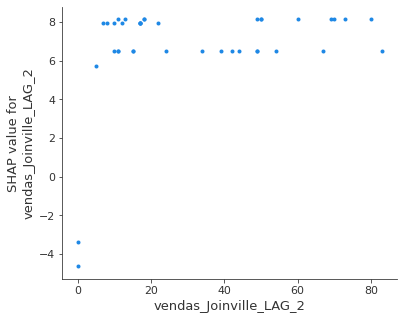

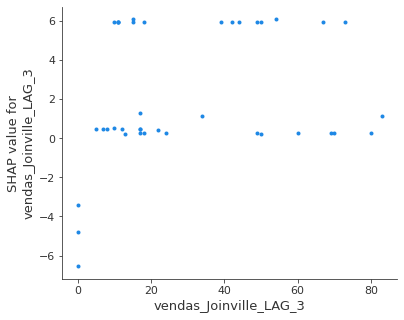

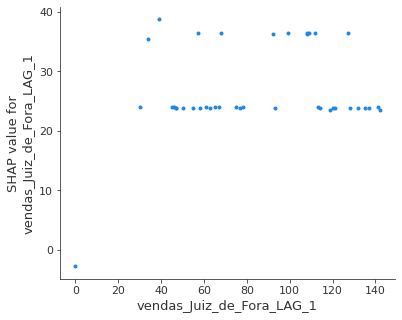

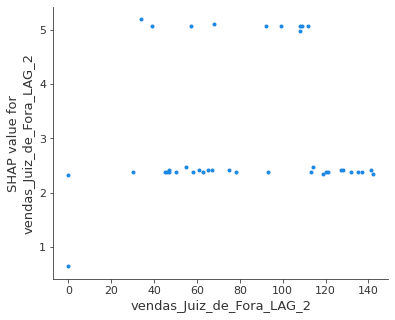

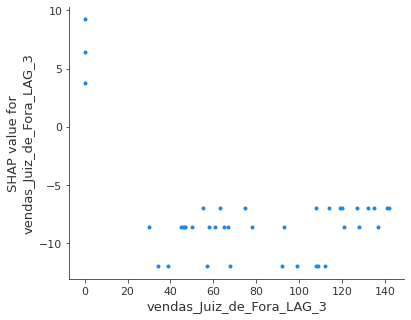

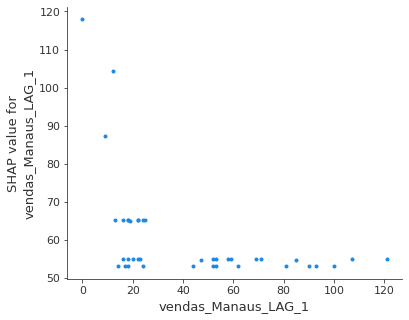

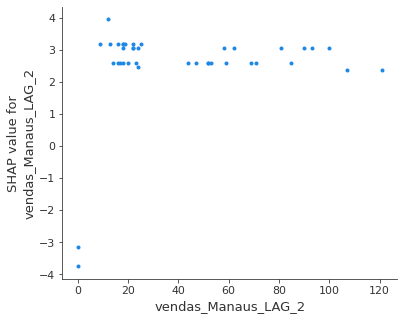

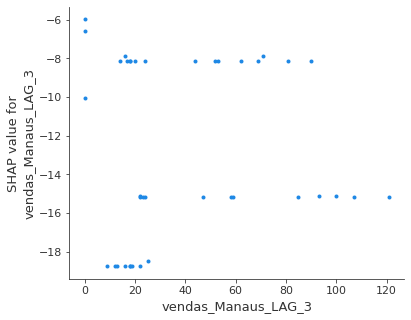

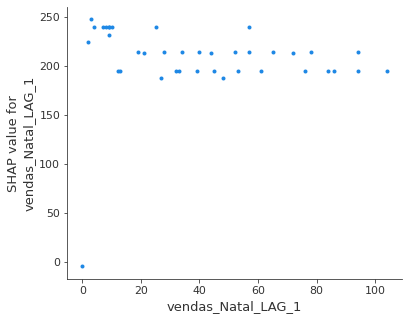

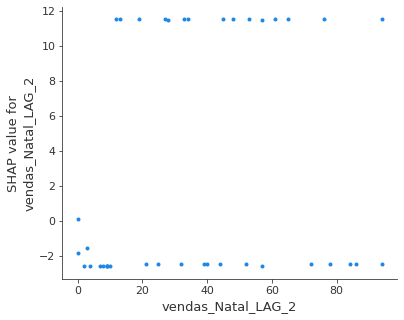

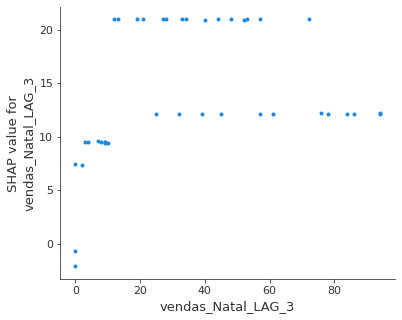

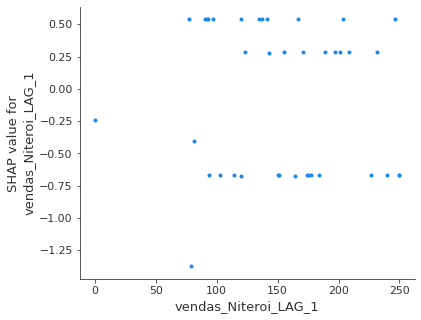

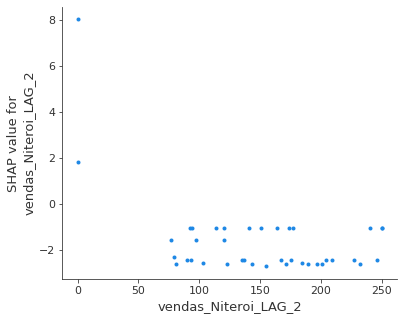

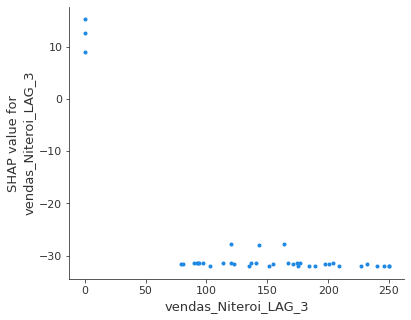

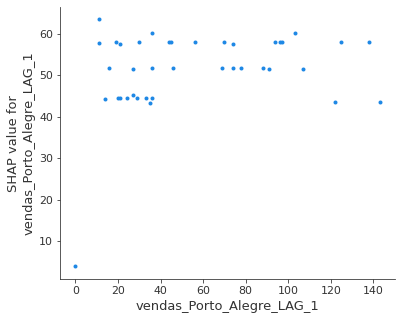

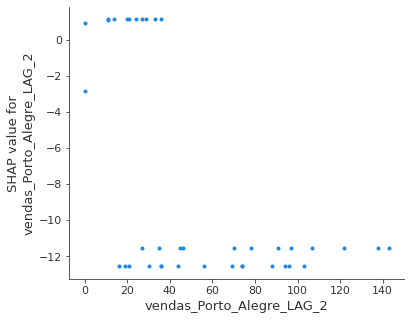

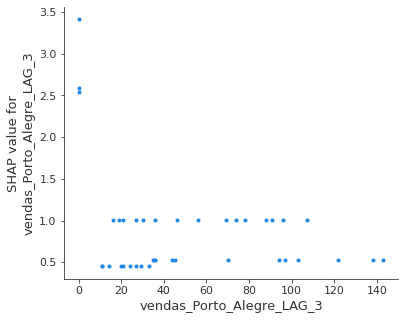

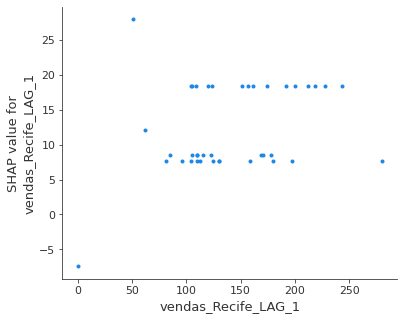

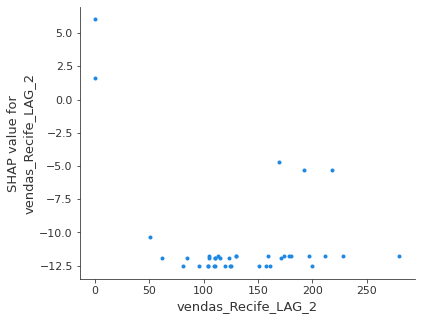

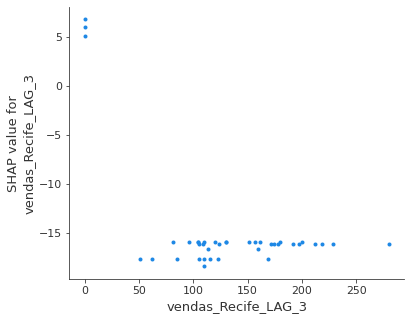

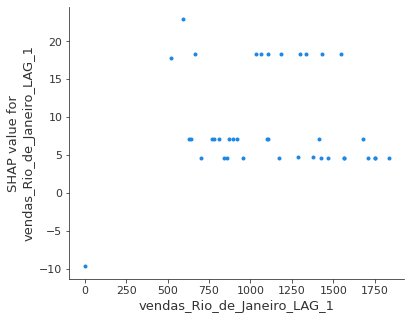

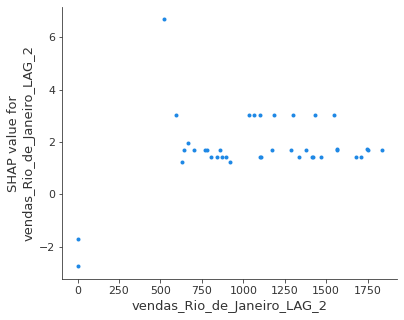

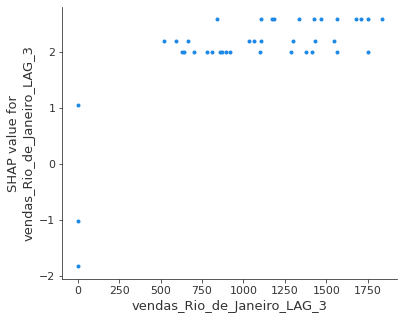

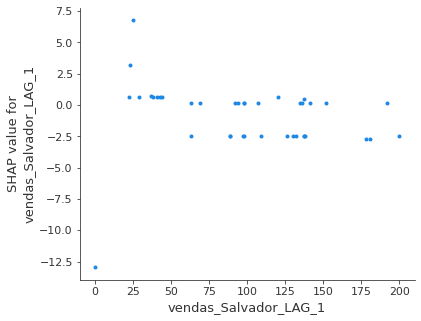

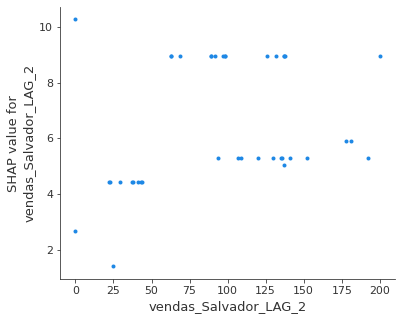

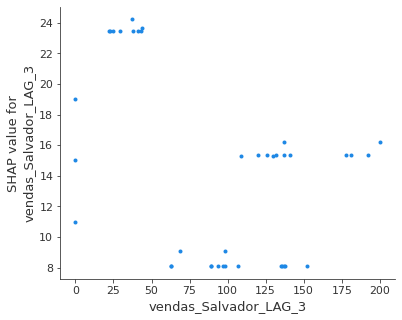

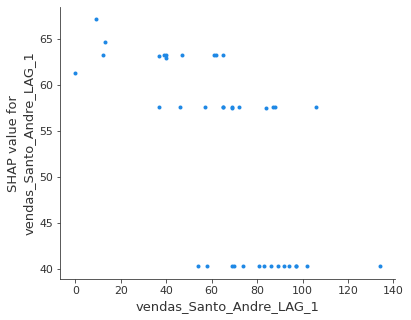

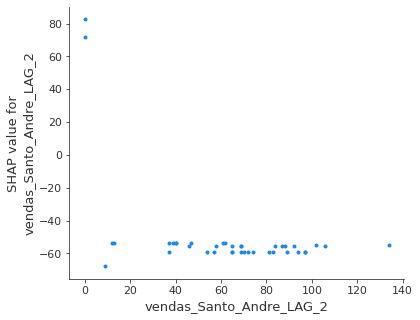

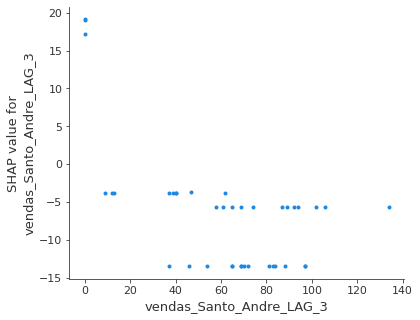

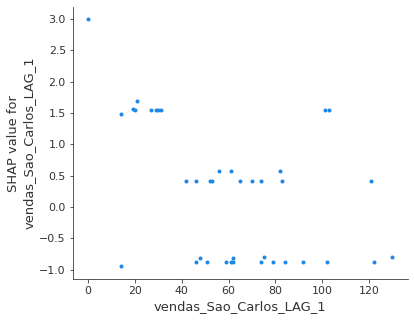

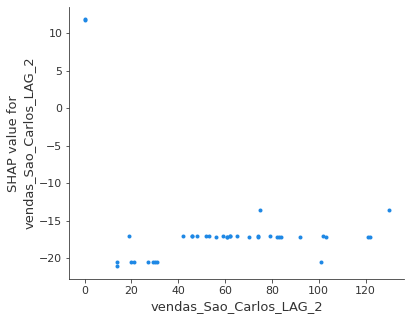

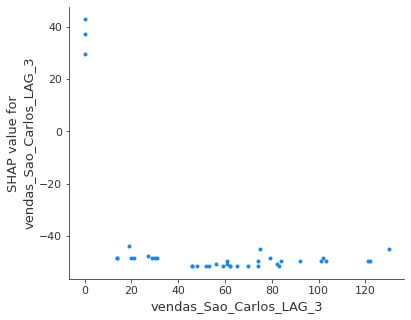

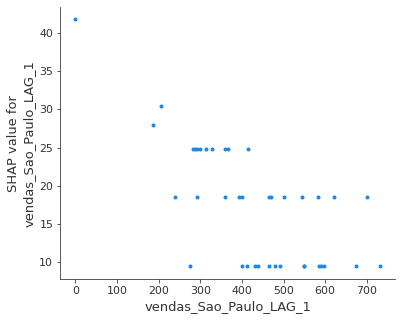

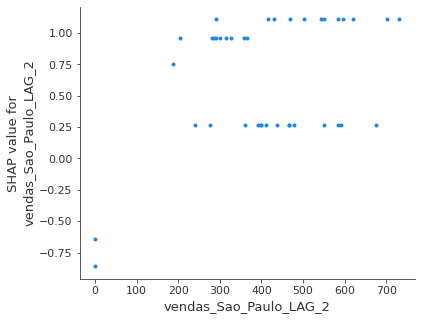

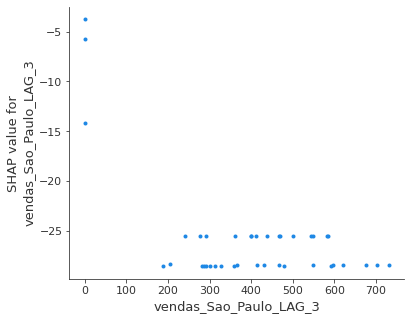

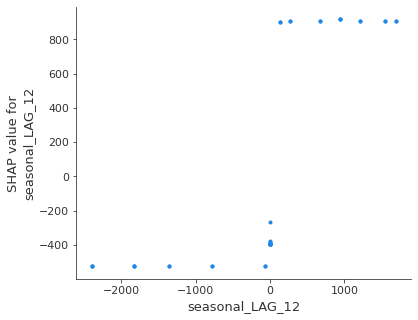

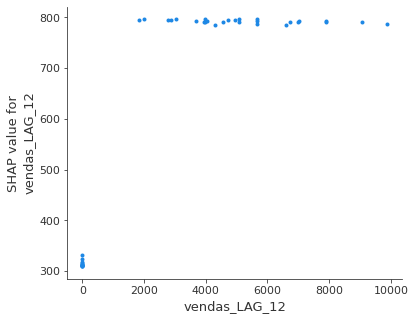

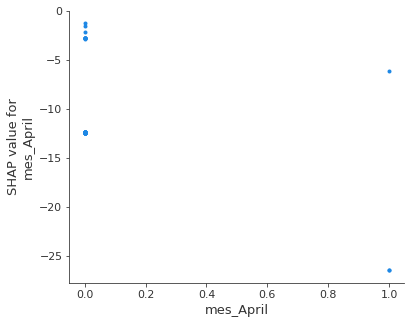

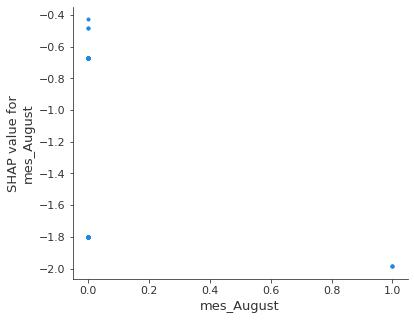

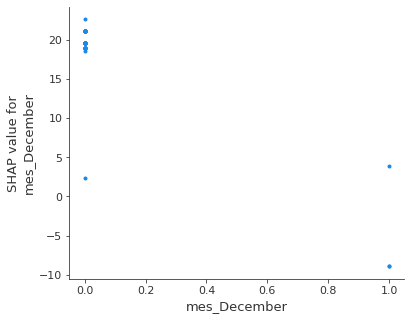

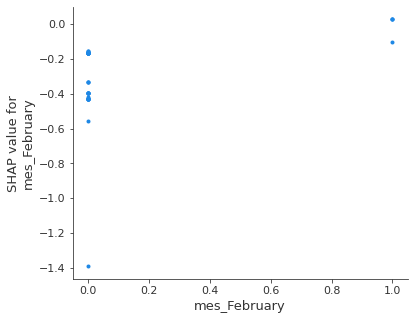

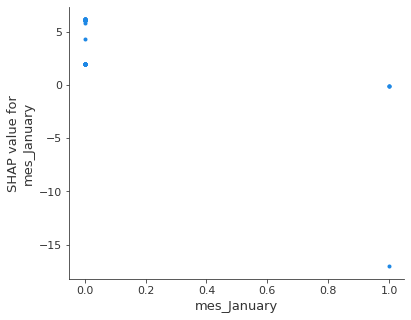

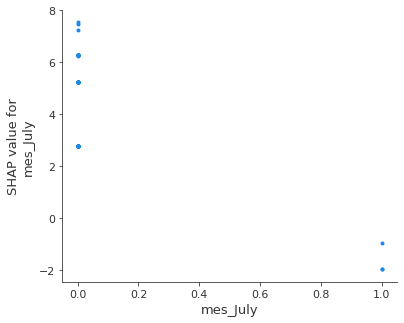

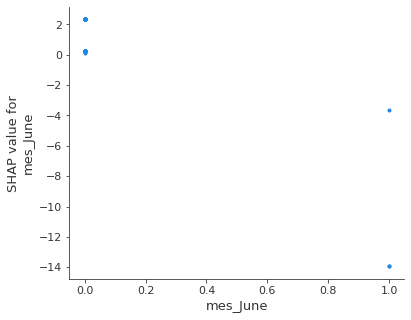

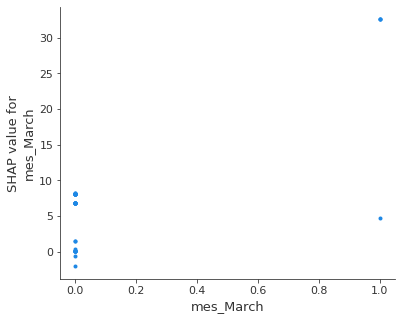

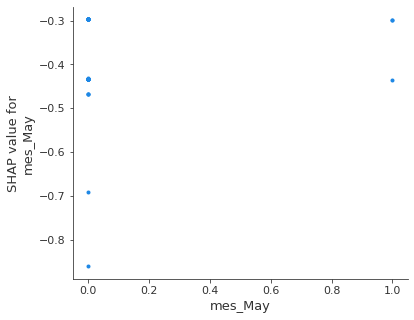

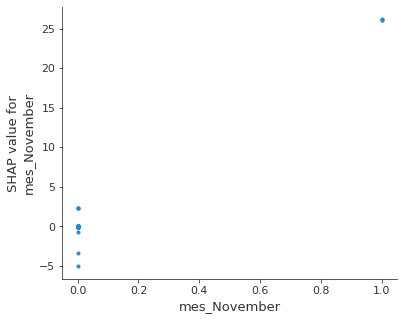

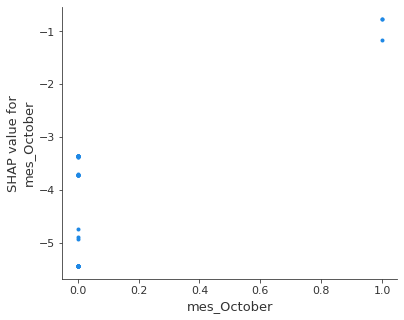

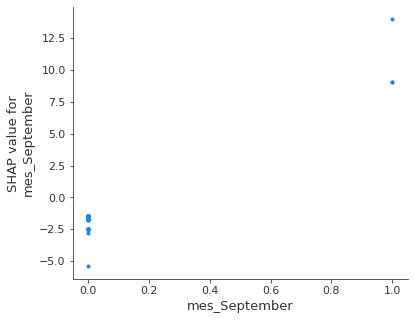

In [92]:
for column in X_r_treino.columns:
  shap.dependence_plot(column, shap_values, X_r_treino, interaction_index=None)

##### Force Plot

In [93]:
shap.force_plot(explainer.expected_value, shap_values[38], X_r_treino.iloc[38,:])